# Simulating Cyclic Voltammograms

In this notebook, Cyclic Voltammograms are simulated by varying voltage while keeping track of adsorbates

In [1]:
#### Import packages
import warnings
warnings.filterwarnings('ignore')

import sys
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy

#### Import functions from PUK.py
sys.path.append('../scripts')
from PUK import on_top_site_vector, hollow_site_vector, pandas_to_DMatrix, pandas_to_DMatrix, surface_to_energies, energies_to_charge_isoterm, charge_isoterm_to_CV, rolling_average_smoothing, surface_to_CV, surface_composition, super_surface_plot, create_surface, plot_voltammograms, create_empty_adsorbates, surface_to_energies_matrices, argmin2d, find_smallest_energy, count_adsorbates, count_adsorbates_full, make_voltage_range, steric_hindrance, plot_CV, simulate_CV


In [3]:
#### Load models
hollow_site_model = xgb.Booster({'nthread': 8})
hollow_site_model.load_model("../models/"+"Hollow_site.model")

on_top_site_model = xgb.Booster({'nthread': 8})
on_top_site_model.load_model("../models/"+"on_top_site.model")

## Simulate surface

In [4]:
#### Simulate surface (and matrices for keeping track of the adsorbates (both hollow and on-top))
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
dim_x, dim_y = 100, 100
surface = create_surface(metals, dim_x, dim_y, "Even")
adsorbates_hollow, adsorbates_on_top = create_empty_adsorbates(dim_x, dim_y)

print(count_adsorbates_full(adsorbates_hollow, adsorbates_on_top))

{'H': 0, 'OH': 0, 'O': 0, 'empty': 20000}


## Simulate surface, adsorbates, varying the voltage

In [5]:
# Set parameters
hysteresis_threshold = 0.0
steric_bonus_energy = 0.10 # Prob between 0.1 - 0.01

voltage_range = make_voltage_range(0.25, 2, -1, 1, 1000) #V_start, V_max, V_min, num_rounds, points_per_round
#voltage_range = [1.8]
#voltage_range = np.linspace(0.1, 1.0, 100)

In [6]:
sum_delta_G_log, adsorbates_log = simulate_CV(surface, voltage_range, hysteresis_threshold, steric_bonus_energy, dim_x, dim_y, adsorbates_hollow, adsorbates_on_top, hollow_site_model, on_top_site_model)


  0%|          | 0/999 [00:00<?, ?it/s]

## Plot the cyclic voltammogram / results

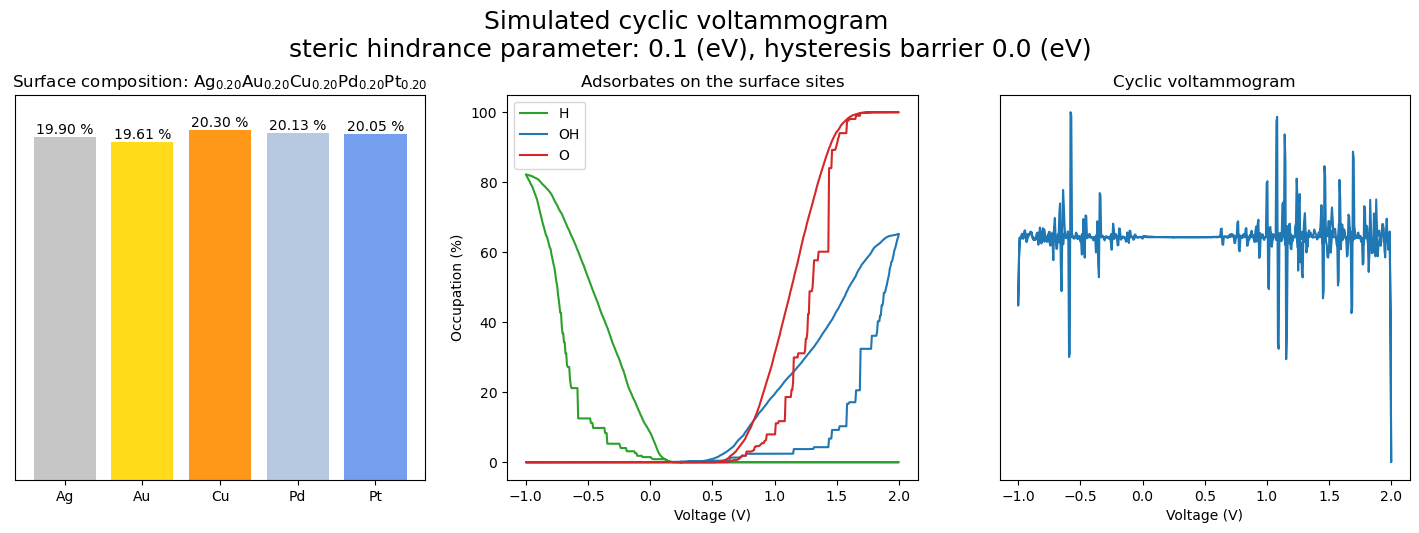

In [7]:
plot_CV(metals, surface, voltage_range, sum_delta_G_log, adsorbates_log, steric_bonus_energy, hysteresis_threshold, filename = f"{time.time()}")


In [99]:
adsorbates_log

[{'H': 127, 'OH': 1, 'O': 0, 'empty': 19872},
 {'H': 115, 'OH': 1, 'O': 0, 'empty': 19884},
 {'H': 101, 'OH': 1, 'O': 0, 'empty': 19898},
 {'H': 86, 'OH': 2, 'O': 0, 'empty': 19912},
 {'H': 77, 'OH': 2, 'O': 0, 'empty': 19921},
 {'H': 70, 'OH': 2, 'O': 0, 'empty': 19928},
 {'H': 61, 'OH': 2, 'O': 0, 'empty': 19937},
 {'H': 51, 'OH': 2, 'O': 0, 'empty': 19947},
 {'H': 42, 'OH': 2, 'O': 0, 'empty': 19956},
 {'H': 33, 'OH': 2, 'O': 0, 'empty': 19965},
 {'H': 31, 'OH': 2, 'O': 0, 'empty': 19967},
 {'H': 20, 'OH': 2, 'O': 0, 'empty': 19978},
 {'H': 14, 'OH': 2, 'O': 0, 'empty': 19984},
 {'H': 7, 'OH': 2, 'O': 0, 'empty': 19991},
 {'H': 3, 'OH': 2, 'O': 0, 'empty': 19995},
 {'H': 1, 'OH': 3, 'O': 0, 'empty': 19996},
 {'H': 0, 'OH': 3, 'O': 0, 'empty': 19997},
 {'H': 0, 'OH': 3, 'O': 0, 'empty': 19997},
 {'H': 0, 'OH': 4, 'O': 0, 'empty': 19996},
 {'H': 0, 'OH': 4, 'O': 0, 'empty': 19996},
 {'H': 0, 'OH': 5, 'O': 0, 'empty': 19995},
 {'H': 0, 'OH': 5, 'O': 0, 'empty': 19995},
 {'H': 0, 'OH': 

In [ ]:
# Smooth the energies with a gaussian? Or are they supposed to be identical?

# Why are there stairs?

In [61]:
np.mean(CV)

9.716302156511509e-12

In [79]:
def plot_CV(metals, surface, voltage_range, sum_delta_G_log, adsorbates_log, steric_bonus_energy, hysteresis_threshold, **filename):
    fig, (ax_a, ax_b, ax_c) = plt.subplots(1, 3, figsize = (18, 5))
    
    ### TITLE ###
    fig.suptitle(f"Simulated cyclic voltammogram \n steric hindrance parameter: {steric_bonus_energy} (eV), hysteresis barrier {hysteresis_threshold} (eV) \n", x = 0.5, y = 1.05,fontsize = 18)
    
    ### SURFACE COMPOSITION ###
    composition, composition_string = surface_composition(metals, surface)
    ymax = max(composition.values()) * 1.1
    ax_a.set_ylim(0, ymax)
    ax_a.set_title("Surface composition: " + composition_string)
    ax_a.set_yticks([])
    #ax.set_xticks([])
    bar1 = ax_a.bar(composition.keys(), composition.values(), alpha = 0.9, color = ["silver", "gold", "darkorange", "lightsteelblue", "cornflowerblue"])
    
    for idx, rect in enumerate(bar1):
        height = rect.get_height()
        fraction = list(composition.values())[idx]*100
        ax_a.text(rect.get_x() + rect.get_width() / 2.0, height, s = f"{fraction:.2f}" + " %", ha='center', va='bottom')
        
    ### ADSORBATES ON SURFACE ###
    adsorbate_colours = {"H": "tab:green", "OH": "tab:blue", "O": "tab:red", "empty": "Grey"}
    for adsorbate in ["H", "OH", "O"]:
        ax_b.plot(voltage_range, [adsorbates_log[n][adsorbate]/100 for n in range(len(adsorbates_log))], c = adsorbate_colours[adsorbate], label = adsorbate)
    
    ax_b.set_title("Adsorbates on the surface sites")
    ax_b.set_xlabel("Voltage (V)")
    ax_b.set_ylabel("Occupation (%)")
    
    ax_b.legend()
    
    ### CYCLIC VOLTAMMOGRAM ###
    CV = -np.gradient(np.gradient(sum_delta_G_log))
    #mid = int(len(voltage_range)/2)
    #remove = 1000
    #ax_c.plot(voltage_range[:mid-remove] + voltage_range[remove+mid:], list(CV[:mid-remove]) + list(CV[mid+remove:]))
    ax_c.plot(voltage_range, CV)
    
    ax_c.set_title("Cyclic voltammogram")
    ax_c.set_xlabel("Voltage (V)")
    #ax_c.set_yticks([])
    ax_c.set_ylim([-0.001, 0.002])
    
    if filename:
        #print("The filename is: ", filename["filename"])
        fig.savefig("../figures/Sim_CV/"+filename["filename"]+".png", dpi = 300, bbox_inches = "tight")
    fig.show()
    return None

### Manual plots for bugfixing

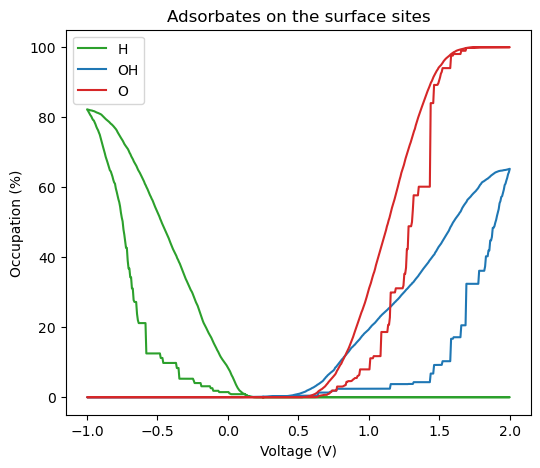

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
adsorbate_colours = {"H": "tab:green", "OH": "tab:blue", "O": "tab:red", "empty": "Grey"}
for adsorbate in ["H", "OH", "O"]:
    ax.plot(voltage_range, [adsorbates_log[n][adsorbate]/100 for n in range(len(adsorbates_log))], c = adsorbate_colours[adsorbate], label = adsorbate)

ax.set_title("Adsorbates on the surface sites")
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Occupation (%)")

ax.legend()
fig.show()

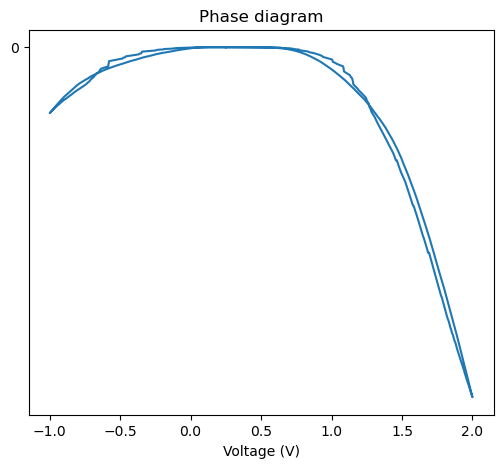

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(voltage_range, sum_delta_G_log)

ax.set_title("Phase diagram")
ax.set_xlabel("Voltage (V)")
ax.set_yticks([0])
fig.show()

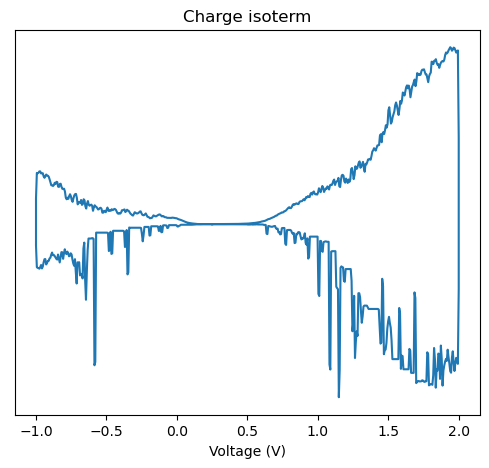

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(voltage_range, np.gradient(sum_delta_G_log))

ax.set_title("Charge isoterm")
ax.set_xlabel("Voltage (V)")
ax.set_yticks([])
fig.show()

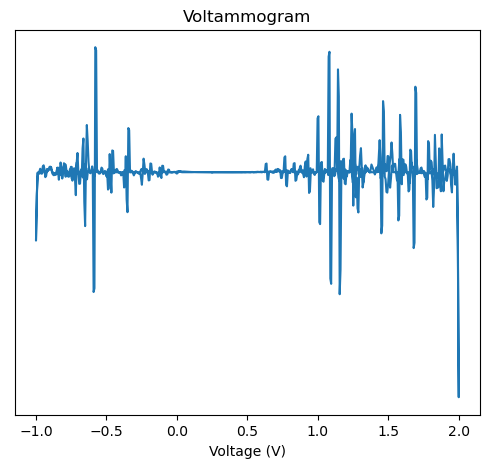

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(voltage_range, -np.gradient(np.gradient(sum_delta_G_log)))

ax.set_title("Voltammogram")
ax.set_xlabel("Voltage (V)")
ax.set_yticks([])
fig.show()